In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

In [4]:
import mediapipe as mp
mp_hands = mp.solutions.hands.Hands(static_image_mode=True,
                                    max_num_hands=1,
                                    min_detection_confidence=0.5)

def detect_bbox_norm(bgr):
    # returns (x1n,y1n,x2n,y2n) in [0,1] or None if not found
    import numpy as np, cv2
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    res = mp_hands.process(rgb)
    if not res.multi_hand_landmarks:
        return None
    lms = res.multi_hand_landmarks[0].landmark
    xs = [lm.x for lm in lms]; ys = [lm.y for lm in lms]
    return float(min(xs)), float(min(ys)), float(max(xs)), float(max(ys))

rows, miss = [], 0
for _, r in manifest.iterrows():
    bgr = cv2.imread(r.path)
    bb  = detect_bbox_norm(bgr)
    if bb is None:
        miss += 1
    else:
        rows.append(dict(path=r.path, cls=int(r.cls),
                         x1n=bb[0], y1n=bb[1], x2n=bb[2], y2n=bb[3]))
bboxes_df = pd.DataFrame(rows)
bboxes_csv = WORK/"bboxes_auto.csv"
bboxes_df.to_csv(bboxes_csv, index=False)

print(f"Auto-boxes saved → {bboxes_csv}")
print(f"Detected: {len(bboxes_df)}  |  Misses: {miss}  ({miss/(len(manifest)+1e-9):.1%})")


C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Auto-boxes saved → C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\bboxes_auto.csv
Detected: 1717  |  Misses: 345  (16.7%)


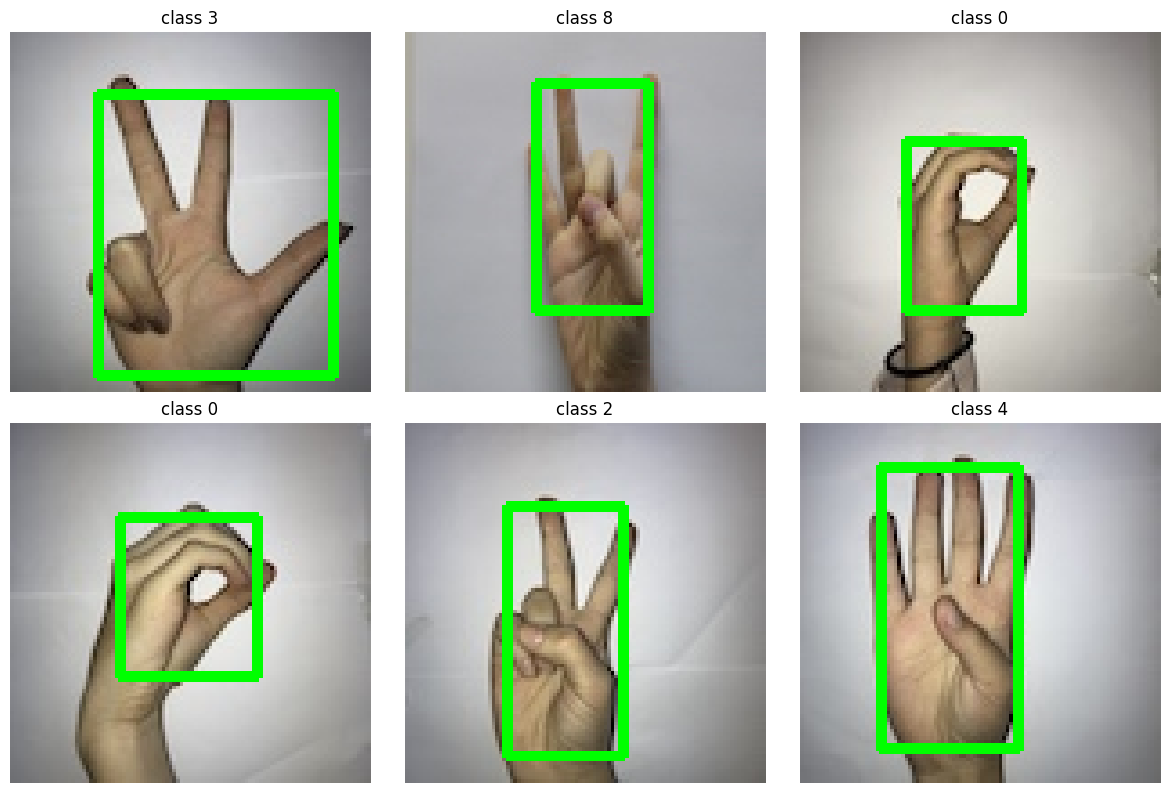

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sample = bboxes_df.sample(6, random_state=RNG_SEED)
plt.figure(figsize=(12,8))
for i,(_,row) in enumerate(sample.iterrows(),1):
    img = cv2.imread(row.path)
    h,w = img.shape[:2]
    x1,y1,x2,y2 = int(row.x1n*w), int(row.y1n*h), int(row.x2n*w), int(row.y2n*h)
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"class {row.cls}")
plt.tight_layout(); plt.show()


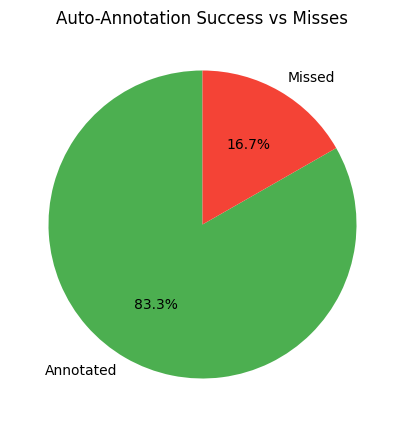

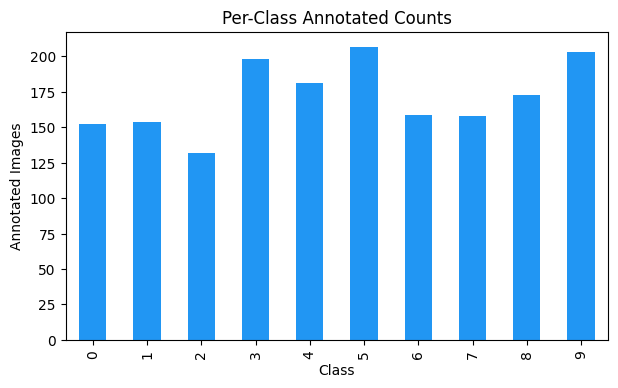

In [6]:
import matplotlib.pyplot as plt

# Plot annotation success vs misses
labels = ["Annotated", "Missed"]
counts = [len(bboxes_df), miss]
colors = ["#4CAF50", "#F44336"]

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Auto-Annotation Success vs Misses")
plt.show()

# Also show per-class annotated count
plt.figure(figsize=(7,4))
bboxes_df.groupby("cls").size().plot(kind="bar", color="#2196F3")
plt.xlabel("Class")
plt.ylabel("Annotated Images")
plt.title("Per-Class Annotated Counts")
plt.show()
